## 보스턴 집값 예측
* 보스턴 외곽지역 집값과 그것들과 관련있는 여러 요소를 변수로 정의









In [1]:
import pandas as pd

In [2]:
import numpy as np

In [3]:
import seaborn as sns

In [4]:
import matplotlib.pyplot as plt

In [5]:
from pyspark.sql.functions import col

In [6]:
boston = spark.read.csv("boston.csv", header=True, inferSchema=True)

In [7]:
boston2 = boston.toPandas()

In [ ]:
boston2.describe()

In [10]:
corrVal = boston.cov('rm', 'medv')

In [11]:
corrVal

4.4934458795444785

In [ ]:
plt.plot('rm', 'mdev', 'ro')

In [ ]:
plt.xlabel('rm')

In [ ]:
plt.ylabel('medv')

In [15]:
plt.show()

In [ ]:
상관계수 행렬

In [ ]:
boston2.corr()

In [ ]:
히트맵을 이용한 상관계수 시각화 1

In [17]:
corrdf = boston2.corr()

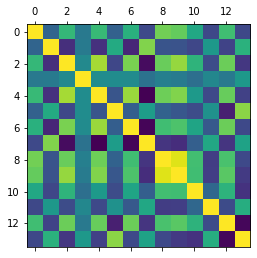

In [18]:
plt.matshow(corrdf)

In [19]:
plt.show()

In [ ]:
히트맵을 이용한 상관계수 시각화 2 - seaborn

In [20]:
plt.figure(figsize=(13, 13))

<Figure size 936x936 with 0 Axes>

<Figure size 936x936 with 0 Axes>

In [ ]:
sns.heatmap(corrdf, anoot =True)

In [ ]:
전처리 - 독립변수 벡터화

In [8]:
from pyspark.ml.linalg import Vector

In [9]:
from pyspark.ml.feature import VectorAssembler

In [16]:
va = VectorAssembler(inputCols=['crim','zn','indus','chas','nox','rm','age','dis','rad','tax','ptratio','black','lstat'], outputCol='features')

In [17]:
boston = va.transform(boston)

### 벡터화한 칼럼 확인

In [18]:
boston.select('features').show(5,False)

21/10/12 00:59:14 WARN Utils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.debug.maxToStringFields' in SparkEnv.conf.


+-------------------------------------------------------------------------+
|features                                                                 |
+-------------------------------------------------------------------------+
|[0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.09,1.0,296.0,15.3,396.9,4.98]  |
|[0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.9,9.14] |
|[0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03]|
|[0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94]|
|[0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.9,5.33] |
+-------------------------------------------------------------------------+
only showing top 5 rows



### 독립변수와 종속변수를 추출해서 새로운 변수 생성

In [26]:
model_df = boston.select('features','medv')

In [27]:
model_df = model_df.withColumnRenamed('medv','label')

In [28]:
model_df.show(5)

+--------------------+-----+
|            features|label|
+--------------------+-----+
|[0.00632,18.0,2.3...| 24.0|
|[0.02731,0.0,7.07...| 21.6|
|[0.02729,0.0,7.07...| 34.7|
|[0.03237,0.0,2.18...| 33.4|
|[0.06905,0.0,2.18...| 36.2|
+--------------------+-----+
only showing top 5 rows



### 훈련셋, 테스트셋 생성

In [29]:
seed = 2110120945

In [30]:
train, test = model_df.randomSplit([0.75, 0.25], seed)

In [31]:
print(f'train set size : {train.count()}')

train set size : 376


In [32]:
print(f'test set size : {train.count()}')

test set size : 376


### 선형회귀분석
+ ML 중요지표 : R^2, 오차값
+ 통계 중요지표 : 

In [24]:
from pyspark.ml.regression import LinearRegression

In [25]:
lr = LinearRegression()

In [33]:
trained = lr.fit(train)

21/10/12 01:10:34 WARN Instrumentation: [592fe417] regParam is zero, which might cause numerical instability and overfitting.
21/10/12 01:10:34 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
21/10/12 01:10:34 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS
21/10/12 01:10:34 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeSystemLAPACK
21/10/12 01:10:34 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeRefLAPACK


In [34]:
pred =trained.transform(test)

In [36]:
pred.select('label', 'prediction').show(5)

+-----+------------------+
|label|        prediction|
+-----+------------------+
| 30.1| 25.12998317867188|
| 33.0| 22.53942393820208|
| 26.6| 21.40474994161692|
| 18.5| 18.95089817175425|
| 19.5|20.038435263360817|
+-----+------------------+
only showing top 5 rows



### 회귀모형 평가

In [37]:
pred = trained.evaluate(test)

In [38]:
pred.r2                # 결정계수 - 적어도 0.75수준은 되어야 써먹을만함

0.6580736858103006

In [39]:
pred.meanSquaredError   # 평균제곱오차

24.690415183484113

In [40]:
trained.coefficients   # 회귀계수 (기울기)

DenseVector([-0.1576, 0.052, 0.0775, 0.9283, -18.0278, 3.8515, -0.0109, -1.6083, 0.3567, -0.014, -1.0167, 0.0115, -0.5283])

In [41]:
trained.intercept      # 회귀계수 (절편)

37.731981265752424

### 범죄율, 단위면적당 거주주민수,

<AxesSubplot:xlabel='crim', ylabel='Density'>

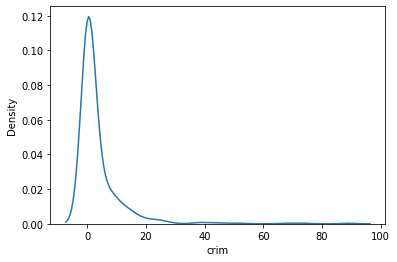

In [13]:
sns.kdeplot(data=boston2, x='crim')

In [ ]:
plt.plot(boston2['Sepal Length'], iris2['Sepal Width'], 'o')

### 비상업지구 거주민, 강근처 주택여부, 오염도 비율,

### 공실비율, 노후주택 비율, 도로 접근성비율,

### 재산세 납부비율, 학생/교사 비율, 유색인종 비율,

### 하위계층 비율, 본인소유 주택가격(유일한 종속변수)

## 최종적으로 집값에 영향을 주는 요인은?